# Lobe segmentation

Follows 3D spleen segmentation with MONAI tutorial

In [1]:
import numpy as np
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Resize,
    AddChannel,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nibabel as nib

In [2]:
def showslice(img, x, y, z, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = img[:,:,z]
    clip_ax = np.rot90(clip_ax)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax= plt.subplots(1,3, figsize=(15,15))
    if is_gray:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)
    
def showSag(img, x, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        sag = plt.imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = plt.imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, fraction=0.046, pad=0.04)

def showCor(img, y, is_gray=False, clip_range=[]):
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        cor = plt.imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        cor = plt.imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(cor, fraction=0.046, pad=0.04)
    
def getSlice(data, x, y, z):
    clip_sag = data[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = data[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = data[:,:,z]
    clip_ax = np.rot90(clip_ax)
    return clip_sag, clip_cor, clip_ax

In [3]:
MODEL_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models"
TMP_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp"

TRAIN_DIR = "/home/local/VANDERBILT/litz/data/imagevu/nifti/train/"
LABEL_DIR = "/home/local/VANDERBILT/litz/data/imagevu/lobe/uniform_lvlsetseg/"

In [4]:
# set dataset paths
train_images = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.nii.gz")))
train_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in train_images]
train_labels = [os.path.join(LABEL_DIR, name) for name in train_file_names] 

# limit to 100 for dev
train_images = train_images[200:205]
train_labels = train_labels[200:205]

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

val_size = 1
train_files, val_files = data_dicts[:-val_size], data_dicts[-val_size:]
# val_size = int(len(train_images)*0.1)
# train_files, val_files = data_dicts[:-val_size], data_dicts[-val_size:]
# print(train_files)

(512, 512, 391)
(512, 512, 320)


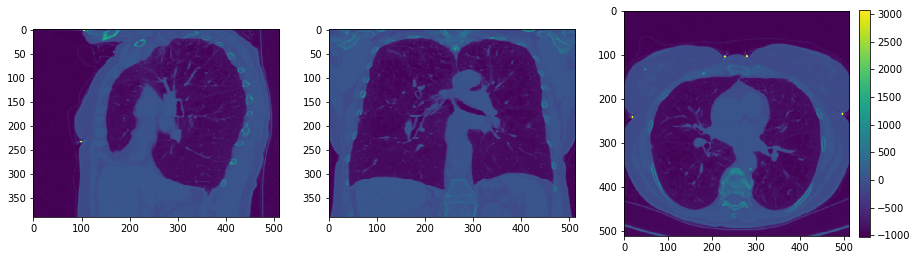

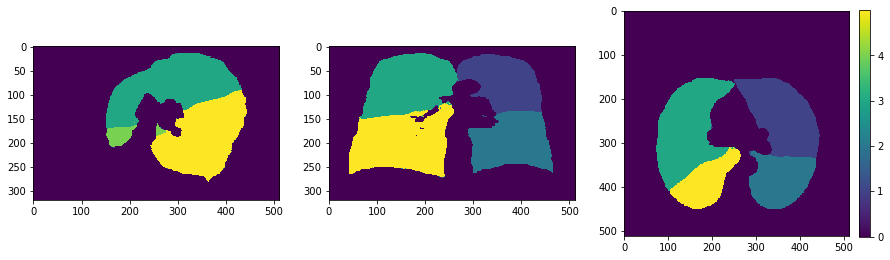

In [5]:
nii = nib.load(train_images[0])
label_nii = nib.load(train_labels[0])
print(nii.header.get_data_shape())
print(label_nii.header.get_data_shape())
showslice(nii.get_fdata(), 200,200,200)
showslice(label_nii.get_fdata(), 200,200,200)

In [6]:
set_determinism(seed=0)

In [14]:
# Transforms
hu_window = [-1024, 600]
train_transforms = Compose(
    [
       LoadImaged(keys=["image", "label"]),
       EnsureChannelFirstd(keys=["image", "label"]),
       Orientationd(keys=["image", "label"], axcodes="RAS"),
       Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
       ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0, clip=True),
       CropForegroundd(keys=["image", "label"], source_key="image"),
       RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96,96,96),
        pos=1,
        neg=1,
        num_samples=6,
        image_key="image",
        image_threshold=0,
       ),
       EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


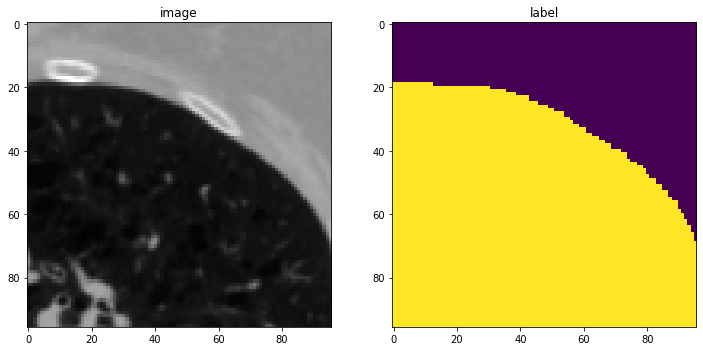

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


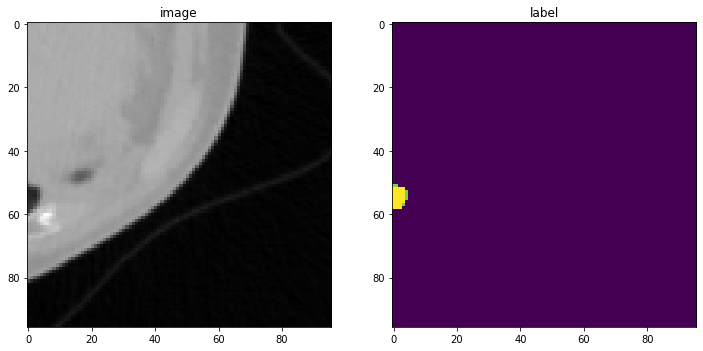

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


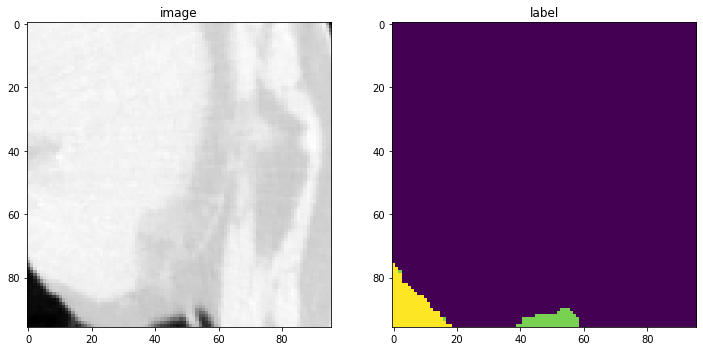

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


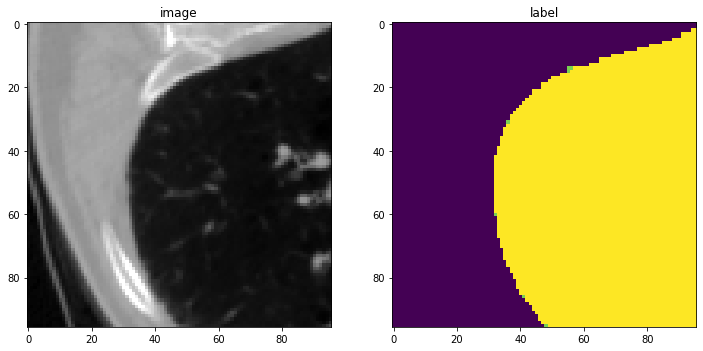

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


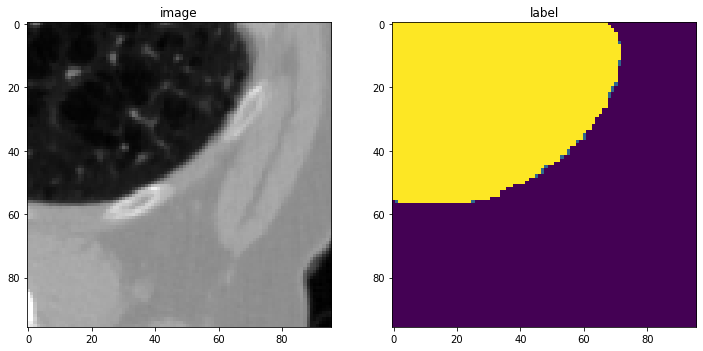

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


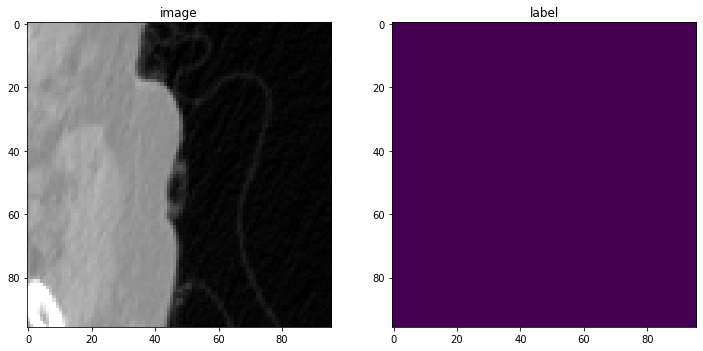

In [15]:
# Check transforms
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
# for batch in check_loader:
#     print(batch["image"].shape, batch["label"].shape)
check_data = first(check_loader)

# for check_data in check_loader:
for i in range(6):
    image, label = (check_data["image"][i][0], check_data["label"][i][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    # showslice(image, 80, 80, 80, is_gray=True)
    plt.imshow(image[:, :, 80], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    # showslice(image, 80, 80, 80)
    plt.imshow(label[:, :, 80])
    plt.show()

In [10]:
label[50:60, 50,50]

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

torch.Size([1, 1, 351, 351, 308]) torch.Size([1, 1, 351, 351, 308])
image shape: torch.Size([351, 351, 308]), label shape: torch.Size([351, 351, 308])


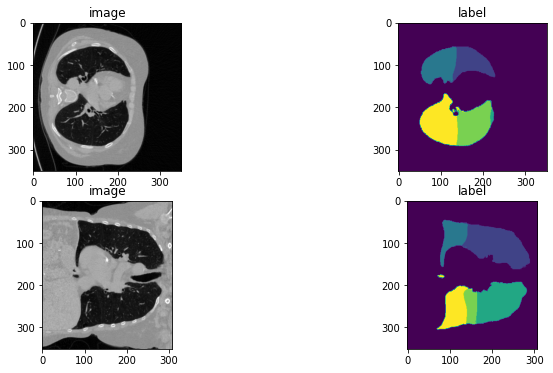

In [28]:
# check validation transforms
check_val = Dataset(data=val_files, transform=val_transforms)
check_val_loader = DataLoader(check_val, batch_size=1)
for batch in check_val_loader:
    print(batch["image"].shape, batch["label"].shape)
check_val_data = first(check_val_loader)
image, label = (check_val_data["image"][0][0], check_val_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(2, 2, 1)
plt.title("image")
# showslice(image, 80, 80, 80, is_gray=True)
plt.imshow(image[:, :, 150], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("label")
# showslice(image, 80, 80, 80)
plt.imshow(label[:, :, 150])
plt.subplot(2, 2, 3)
plt.title("image")
# showslice(image, 80, 80, 80, is_gray=True)
plt.imshow(image[:, 150, :], cmap="gray")
plt.subplot(2, 2, 4)
plt.title("label")
# showslice(image, 80, 80, 80)
plt.imshow(label[:, 150, :])
plt.show()

In [8]:
# Hyperparams and constants
BATCH_SIZE=1
LR = 1e-4
EPOCHS=10
VAL_INTERVAL=2 # Interval at which to compute validation metrics
NUM_CLASSES=6
LABEL_SHAPE=(512,512,320) # All labels have this shape, but input shapes vary

In [9]:
# Initialize Dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader=DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader=DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████| 1/1 [00:08<00:00,  8.89s/it]


In [10]:
# Initialize Model, Loss, and Optimizer
device = torch.device("cuda:0")
model=UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=NUM_CLASSES,
    channels=(16, 32, 64, 128, 256),
    strides=(2,2,2,2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [11]:
# Training protocol

best_metric=-1
best_metric_epoch=-1
epoch_loss_values=[]
val_metrics=[]
post_pred=Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)])
post_label=Compose([EnsureType(), AsDiscrete(to_onehot=NUM_CLASSES)])

for epoch in range(EPOCHS):
    print("-" * 20)
    print(f"epoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss=0
    step=0
    for batch in train_loader:
        step += 1
        inputs, labels = (
            batch["image"].to(device),
            batch["label"].to(device),
        )
        optimizer.zero_grad()
        # print(batch["image"].shape)
        # print(labels.shape)
        # break
        outputs=model(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() # accumulate loss of epoch
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    # break
    epoch_loss /= step # avg loss of the epoch
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # validate
    if (epoch+1) % VAL_INTERVAL==0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels= (
                val_data["image"].to(device),
                val_data["label"].to(device),
            )
            roi_size=(160, 160, 160)
            sw_batch_size=4
            # Run over the input image with a sliding window, run inference on each fragment and then aggregate to get the overall result.
            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
            val_outputs=[post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels=[post_label(i) for i in decollate_batch(val_labels)]
            
            # compute dice for current iter
            dice_metric(y_pred=val_outputs, y=val_labels)
        
        # total dice over validation set
        metric = dice_metric.aggregate().item()
        val_metrics.append(metric)
        dice_metric.reset()
        
        if metric > best_metric:
            best_metric=metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_model.pth"))
            print("Saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f"\nbest mean dice: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}"
        )

--------------------
epoch 1/10
1/1, train_loss: 0.9160
epoch 1 average loss: 0.9160
--------------------
epoch 2/10
1/1, train_loss: 0.9157
epoch 2 average loss: 0.9157
Saved new best metric model
current epoch: 2 current mean dice: 0.0281
best mean dice: 0.0281 at epoch: 2
--------------------
epoch 3/10
1/1, train_loss: 0.8984
epoch 3 average loss: 0.8984
--------------------
epoch 4/10
1/1, train_loss: 0.8941
epoch 4 average loss: 0.8941
current epoch: 4 current mean dice: 0.0260
best mean dice: 0.0281 at epoch: 2
--------------------
epoch 5/10
1/1, train_loss: 0.8977
epoch 5 average loss: 0.8977
--------------------
epoch 6/10
1/1, train_loss: 0.9059
epoch 6 average loss: 0.9059
current epoch: 6 current mean dice: 0.0212
best mean dice: 0.0281 at epoch: 2
--------------------
epoch 7/10
1/1, train_loss: 0.9088
epoch 7 average loss: 0.9088
--------------------
epoch 8/10
1/1, train_loss: 0.8808
epoch 8 average loss: 0.8808
current epoch: 8 current mean dice: 0.0192
best mean dice:

In [12]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0281 at epoch: 2


In [14]:
np.array(epoch_loss_values)
np.array(val_metrics)

array([0.02812148, 0.02600427, 0.02120916, 0.01918327, 0.01721143])

In [ ]:
# Plot training loss and validation dice 
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [VAL_INTERVAL * (i + 1) for i in range(len(val_metrics))]
y = val_metrics
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

torch.Size([1, 6, 364, 364, 323])
torch.Size([1, 1, 364, 364, 323])
torch.Size([1, 1, 364, 364, 323])


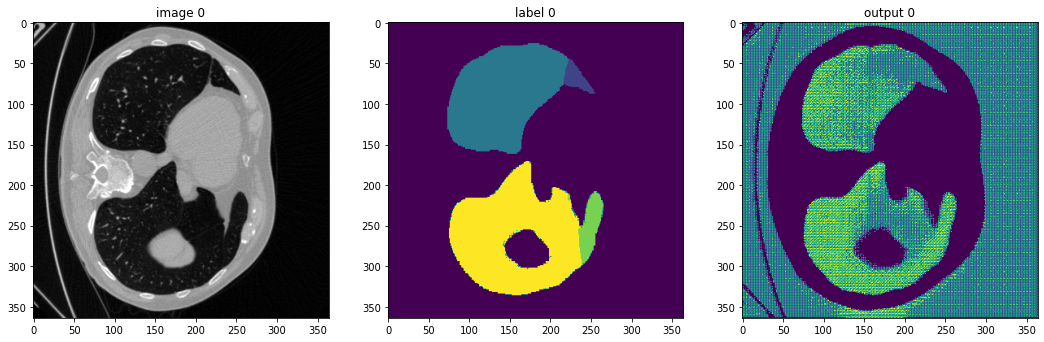

torch.Size([1, 6, 351, 351, 330])
torch.Size([1, 1, 351, 351, 330])
torch.Size([1, 1, 351, 351, 330])


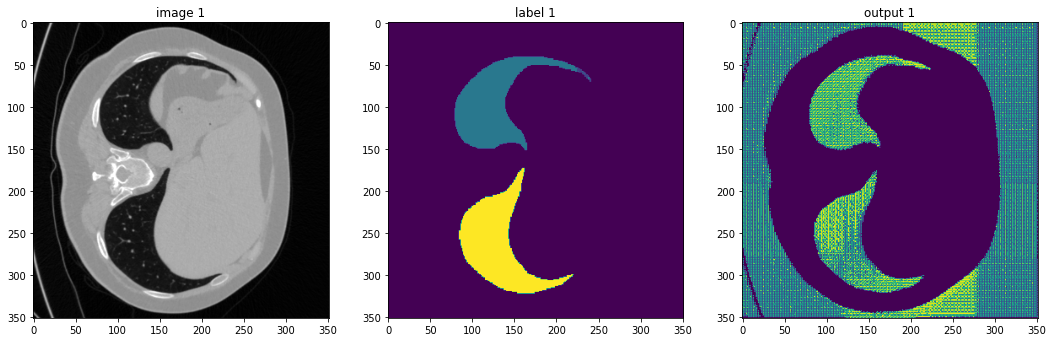

In [82]:
model.load_state_dict(torch.load(
    os.path.join(MODEL_DIR, "best_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        print(val_outputs.shape)
        print(val_data["image"].shape)
        print(val_data["label"].shape)
        # plot the slice [:, :, 80]
        plt.subplot(1,3,1)
        showCor(val_data["image"][0,0,:,:,:], 200, is_gray=True)
        plt.subplot(1,3,2)
        showCor(val_data["label"][0,0,:,:,:], 200)
        plt.subplot(1,3,3)
        output = torch.argmax(val_outputs, dim=1).detach().cpu()[0,:,:,:]
        showCor(output, 200)
        plt.show()
        
        # plt.figure("check", (18, 6))
        # plt.subplot(1, 3, 1)
        # plt.title(f"image {i}")
        # plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        # plt.subplot(1, 3, 2)
        # plt.title(f"label {i}")
        # plt.imshow(val_data["label"][0, 0, :, :, 80])
        # plt.subplot(1, 3, 3)
        # plt.title(f"output {i}")
        # plt.imshow(torch.argmax(
        #     val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        # plt.show()
        if i == 2:
            break

In [104]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_org_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1, 1, 1), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Resize(LABEL_SHAPE)
])

# post_transforms = Compose([
#     EnsureTyped(keys="pred"),
#     Invertd(
#         keys="pred",
#         transform=val_org_transforms,
#         orig_keys="image",
#         meta_keys="pred_meta_dict",
#         orig_meta_keys="image_meta_dict",
#         meta_key_postfix="meta_dict",
#         nearest_interp=False,
#         to_tensor=True,
#     ),
#     # AddChannel(),
#     Resize(spatial_size=(512,512,320)),
#     AsDiscreted(keys="pred", argmax=True, to_onehot=NUM_CLASSES),
#     AsDiscreted(keys="label", to_onehot=NUM_CLASSES),
#     # resize image to label size of (512,512,320)
# ])

In [109]:
val_data
torch.cuda.empty_cache()
for val_data in val_org_loader:
    val_inputs = val_data["image"].to(device)
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    # val_outputs = post_transforms(val_inputs)
    # print(val_outputs[0].shape)
    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
    val_outputs = [post_transforms(i) for i in decollate_batch(val_outputs)]
    print(val_outputs[0].shape)
    # print(val_labels[0].shape)

RuntimeError: CUDA out of memory. Tried to allocate 164.00 MiB (GPU 0; 15.74 GiB total capacity; 13.50 GiB already allocated; 90.44 MiB free; 13.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [95]:
model.load_state_dict(torch.load(
    os.path.join(MODEL_DIR, "best_model.pth")))
model.eval()
    
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        # output is (364, 364, 323). post_transform recovers original size
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        print(val_outputs[0].shape)
        print(val_labels[0].shape)
        break
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

RuntimeError: applying transform <monai.transforms.spatial.array.Resize object at 0x7f97183b1be0>